# Recommendation Chatbot API: Evaluation

In [1]:
%%capture output
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

BASE_PATH    = '../..'
API_PATH     = f'{BASE_PATH}/chat-bot-api'
LIB_PATH     = f'{BASE_PATH}/lib'
DATASET_PATH = f'{BASE_PATH}/datasets'
METRICS_PATH = f'{BASE_PATH}/metrics'
EVAL_METRICS_PATH = f'{METRICS_PATH}/evaluation-metrics.dt'

os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'

sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

In [3]:
import logging
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import pytorch_common.util as pu
import util as ut

import client
from faker import Faker

import metric as mt
from statistics import mean

# Common Functions and Classes

In [4]:
def genres_count(interactions_test_set, items, user_id):
    df = interactions_test_set[interactions_test_set['user_id'] == user_id]

    item_ids = df['item_id'].unique()
    
    genres = []
    for item_id in item_ids:
        genres.extend(items[items['movie_id'] == item_id]['movie_genres'].tolist()[0])

    return pd.Series(genres).value_counts().reset_index(name='count')



def releases(interactions_test_set, items, user_id):
    df = interactions_test_set[interactions_test_set['user_id'] == user_id]

    return np.sort(items[items['movie_id'].isin(df['item_id'].unique())]['movie_release_year'].unique())

In [5]:
def create_fake_profiles(interactions_test_set, items):
    fake = Faker()

    to_email = lambda name: name.lower().replace(' ', '.') + '@gmail.com'

    user_ids = interactions_test_set['user_id'].unique()

    profiles = []
    emails   = []
    profile_user_ids = []
    for user_id in user_ids:        
        while True:
            name  = fake.name()
            email = to_email(name)
            if email not in emails:
                break

        profile_user_ids.append(user_id)
        emails.append(email)

        genres_count_df = genres_count(interactions_test_set, items, user_id=user_id)
        genres = genres_count_df[genres_count_df['count'] >= 10]['index'].tolist()
    
        release = str(releases(interactions_test_set, items, user_id=user_id)[0])
    
        profiles.append(client.UserProfileDto(
            name             = name,
            email            = email,
            preferred_from   = release,
            preferred_genres = genres
        ))

    logging.debug(f'Profiles: {len(profiles)}')
    logging.debug(f'Users: {len(user_ids)}')
    
    return profiles, profile_user_ids

In [6]:
def reset_env(
    api_client,
    interactions_test_set,
    items
):
    for profile in api_client.profiles():
        api_client.remove_interactions_by_user_id(profile.email)
        api_client.delete_profile(profile.email)

    profiles, user_ids = create_fake_profiles(interactions_test_set, items)

    [api_client.add_profile(profile) for profile in profiles]

    return profiles, user_ids

In [7]:
class RecQueryBuilder:
    def __init__(self, settings):
        self.settings = settings

    def user(self, value):
        self.user_id = value
        return self

    def prompt(self, value):
        self.prompt = value
        return self

    def build(self):
        return {
            'message': {
                'author': self.user_id,
                'content': self.prompt
            },
            'settings': self.settings
        }

In [8]:
def smooth_lineplot(
    x, 
    y,
    smooth_level              = 0.7,
    confidence_interval_alpha = 0.15,
    label                     = ''
):
    y_smooth = gaussian_filter1d(
        y,
        sigma = smooth_level
    )

    error = np.abs(y_smooth - y)

    sns.lineplot(
        x     = x,
        y     = y_smooth,
        label = label
    )
    plt.fill_between(
        x, 
        y_smooth - error, 
        y_smooth + error, 
        alpha = confidence_interval_alpha
    )

In [9]:
def plot_mean_ndgc_evolution(
    values, 
    smooth_level = 2,
    figsize      =(5,3)
):
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    
    smooth_lineplot(
        x                         = list(range(1, len(values)+1)),
        y                         = values,
        smooth_level              = smooth_level
    )
    
    plt.xlabel("Session step")
    plt.ylabel("Mean user NDGC")
    plt.title("Mean user NDGC by session step")


def plot_ndcg_sessions(
    ndcgs_by_sessions_size,
    n_users_by_session_size,
    smooth_level = 0.8,
    figsize      =(14, 5)
):
    plt.figure(figsize=figsize)

    for size, ndcgs in sorted(ndcgs_by_sessions_size.items()):
        smooth_lineplot(
            x                         = list(range(1, len(ndcgs)+1)),
            y                         = ndcgs,
            label                     = f'{size} Session steps ({n_users_by_session_size[size]} users)',
            smooth_level              = smooth_level
        )
    
    plt.xlabel("Session step")
    plt.ylabel("Mean user NDGC")
    plt.title("Mean user NDGC by session step")
    plt.legend()


def plot_n_users_by_session_evolution_size(
    users_by_sessions_size,
    figsize =(5 ,4)
):
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=[i[0] for i in users_by_sessions_size], y=[i[1] for i in users_by_sessions_size], estimator="sum")
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.xlabel("Sessions steps")
    plt.ylabel("Users Count")
    plt.title("Users count by sessions steps")
    plt.legend()

In [10]:
class Session:
    def __init__(self, session):
        self.session = session

    @property
    def recommended_item_ids(self):
        return list(self.session['recommended_item_ratings'].keys())

    @property
    def relevant_item_ids(self):
        return list(self.session['relevant_item_ratings'].keys())

    @property
    def recall(self):
        return np.array(recall(self.recommended_item_ids, self.relevant_item_ids))

In [44]:
class EvaluationState:    
    
    @staticmethod
    def load():
        return ut.Picket.load(EVAL_METRICS_PATH)

    
    @staticmethod
    def create(
        hyper_params,
        recomendation_size = 5,
        max_patience       = 5,
        plot_interval      = 10,
        verbose            = False
    ):
        if not os.path.exists(EVAL_METRICS_PATH):
            if not verbose: api_client.verbose_off
            profiles, user_ids  = reset_env(api_client, interactions_test_set, items)
            if not verbose: api_client.verbose_on

            return EvaluationState(
                recomendation_size,
                max_patience,
                plot_interval,            
                profiles, 
                user_ids, 
                hyper_params
            )
        else:
            return EvaluationState.load()


    def __init__(
        self,
        recomendation_size,
        max_patience,
        plot_interval,
        profiles,
        user_ids,
        hyper_params
    ):
        self.recomendation_size  = recomendation_size
        self.max_patience        = max_patience
        self.plot_interval       = plot_interval
        self.profiles            = profiles
        self.hyper_params        = hyper_params 
        
        self.profiles_by_user_id  = { u: p for p, u in zip(profiles, user_ids) }
        self.metrics_by_user_id  = {}
        

    def save(self):
        ut.Picket.save(EVAL_METRICS_PATH, self)


    def find_profile_by_user_id(self, user_id):
        return self.profiles_by_user_id[user_id]


    def was_evaluated(self, user_id):
        return user_id in self.metrics_by_user_id


    def save_session(self, user_id, session):
        if user_id not in self.metrics_by_user_id:
            self.metrics_by_user_id[user_id] = []
        self.metrics_by_user_id.get(user_id).append(session)


    def _update_sessions_ndcg(self, sessions):
        for session in sessions:
            if 'ndgc' in session:
                continue
            ordered_user_asigned_ratings = []
            for rec_item in session['recommended_items']:
                if int(rec_item) in session['relevant_item_ratings']:
                    ordered_user_asigned_ratings.append(session['relevant_item_ratings'][int(rec_item)])
            session['ndgc'] = mt.ndcg(ordered_user_asigned_ratings)


    def session_ndgc_evolution(self):
        sessions_ndgc = []
    
        max_sessions = 0
        for user_id, sessions in self.metrics_by_user_id.items():
            self._update_sessions_ndcg(sessions)
    
            values = [session['ndgc'] for session in sessions]
            if len(values) > max_sessions:
                max_sessions = len(values)
    
            sessions_ndgc.append(values)
    
        rows = []
        for values in sessions_ndgc:
            rows.append(np.pad(
                np.array(values), 
                (0, max_sessions - len(values)), 
                mode            = 'constant', 
                constant_values = 0
            ))
        
        return np.array(rows)
    
    
    def ndgc_evolution_by_session_size(self):
        groups = {}
    
        for user_id, sessions in self.metrics_by_user_id.items():
            self._update_sessions_ndcg(sessions)
    
            values = [session['ndgc'] for session in sessions]
                
            if len(values) < 2:
                continue
    
            if len(values) in groups:
                groups[len(values)] = np.vstack((groups[len(values)], values))
            else:
                groups[len(values)] = np.array(values)
    
        return dict(sorted(groups.items()))
    

    def mean_ndgc_evolutions(self):    
        return {size: np.mean(matrix, axis=0) for size, matrix in self.ndgc_evolution_by_session_size().items() if len(matrix.shape) > 1 }


    def mean_ndgc_evolution(self):
        return nanmean(self.session_ndgc_evolution(), axis=0)


    def n_users_by_session_size(self):
       return {(size, len(users)) for size, users in evaluation_state.ndgc_evolution_by_session_size().items()}

    
    def plot_metrics(self):
        plot_ndcg_sessions(
            self.mean_ndgc_evolutions(), {i[0]: i[1] for i in self.n_users_by_session_size()},
            smooth_level = 0.8,
            figsize      = (14, 6)
        )

        plot_mean_ndgc_evolution(
            self.mean_ndgc_evolution(),
            smooth_level = 1,
            figsize      = (14, 6)
        )

        plot_n_users_by_session_evolution_size(
            evaluation_state.n_users_by_session_size(),
            figsize      = (14, 4)
        )

        plt.show()

        logging.info(f'Mean Reciprocal Rank: {self.mean_reciprocal_rank():.2}')
        logging.info(f'Mean Average Precision: {self.mean_average_precision():.2}')
        logging.info(f'Recall: {self.recall():.2}')


    def sessions(self):
        return [Session(user_session) for user_sessions in self.metrics_by_user_id.values() for user_session in user_sessions]


    def mean_reciprocal_rank(self):
        return mean_reciprocal_rank(
            [s.recommended_item_ids for s in self.sessions()],   
            [s.relevant_item_ids for s in self.sessions()]
        )


    def mean_average_precision(self):
        return mean_average_precision(
            [s.recommended_item_ids for s in self.sessions()],   
            [s.relevant_item_ids for s in self.sessions()]
        )


    def recall(self):
        return np.stack([session.recall for session in self.sessions()]).mean()

In [12]:
def sample(df, size): return df.sample(frac = 1).head(size)

def is_in(df1, left_col, df2, right_col): return df1[df1[left_col].isin(df2[right_col])]

def is_remaining(df, api_client, profile):
    user_voted_item_ids       = [int(i.item_id) for i in api_client.interactions_by_user(profile.email)]
    return df[~df['item_id'].isin(user_voted_item_ids)]

def n_items(df): return len(df["item_id"].unique())

def make_request(
    api_client,
    hyper_params,
    log_prefix,
    profile,
    remaining_items_sample
):
        titles = f'\n'.join([f'- {e}' for e in remaining_items_sample["movie_title"].values.tolist()])
        prompt = f'I want to see:\n{titles}'
    
        logging.debug(f'{log_prefix}Promp: {prompt}')

        return api_client.recommendations(
            RecQueryBuilder(hyper_params) \
                .user(profile.email) \
                .prompt(prompt) \
                .build() 
        ), prompt

In [13]:
def nanmean(arr, axis=0):
    arr = arr.T if axis==0 else arr
    
    result = []    
    for axi_values in arr:
        axi_values = axi_values[axi_values != 0]
        if len(axi_values) > 0:
            result.append(np.mean(axi_values))
    return np.array(result)


def nanmedian(arr, axis=0):
    arr = arr.T if axis==0 else arr
    
    result = []    
    for axi_values in arr:
        axi_values = axi_values[axi_values != 0]
        if len(axi_values) > 0:
            result.append(np.median(axi_values))
    return np.array(result)

In [22]:
def recall(
    recommended_items,
    relevant_items
):
    # Calculate the intersection of recommended_items and relevant_items
    true_positive = len(set(recommended_items).intersection(set(relevant_items)))

    # Calculate the total number of relevant items
    total_relevant_items = len(relevant_items)

    return true_positive / total_relevant_items if total_relevant_items > 0 else 0


def mean_reciprocal_rank(
    recommended_items_list,
    relevant_items_list
):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    reciprocal_ranks = []

    # Iterate through the lists of recommended items and relevant items for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        # Find the reciprocal rank for each user
        for rank, item in enumerate(recommended_items, start=1):
            if item in relevant_items:
                reciprocal_ranks.append(1 / rank)
                break
        else:
            reciprocal_ranks.append(0)

    return sum(reciprocal_ranks) / len(reciprocal_ranks)


def average_precision(
    recommended_items,
    relevant_items
):
    true_positives = 0
    sum_precisions = 0

    for rank, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            true_positives += 1
            precision_at_rank = true_positives / rank
            sum_precisions += precision_at_rank

    return sum_precisions / len(relevant_items) if len(relevant_items) > 0 else 0


def mean_average_precision(
    recommended_items_list,
    relevant_items_list
):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    average_precisions = []

    # Calculate the average precision for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        ap = average_precision(recommended_items, relevant_items)
        average_precisions.append(ap)

    # Calculate the mean average precision across all users
    map_value = sum(average_precisions) / len(average_precisions)
    return round(map_value, 2)


# By user and total.
def catalog_coverage(
    recommended_items_list,
    catalog_items
):
    # Flatten the list of recommended items and convert it to a set
    unique_recommended_items = set(item for sublist in recommended_items_list for item in sublist)

    # Calculate the intersection of unique recommended items and catalog items
    covered_items = unique_recommended_items.intersection(catalog_items)

    return len(covered_items) / len(catalog_items)


def serendipity(
    recommended_items_list,
    relevant_items_list,
    popular_items,
    k = 10
):
    serendipity_score = 0
    total_users = len(recommended_items_list)

    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        # Select the top-k recommended items
        top_k_recommended = recommended_items[:k]

        # Find the serendipitous items by removing popular items from relevant items
        serendipitous_items = set(relevant_items) - set(popular_items)

        # Count the number of serendipitous items in the top-k recommendations
        serendipitous_recommendations = len(set(top_k_recommended) & serendipitous_items)

        # Calculate the proportion of serendipitous items in the top-k recommendations
        serendipity_score += serendipitous_recommendations / k

    return serendipity_score / total_users

## Setup

In [14]:
def on_file(file_path, format='%(asctime)s - %(levelname)s - %(message)s'):
    handler = logging.FileHandler(file_path)
    handler.setFormatter(logging.Formatter(format))
    return handler

pu.LoggerBuilder() \
    .handler(on_file('./evaluation.log'))\
    .on_console() \
    .build()

<RootLogger root (INFO)>

**Step 1**: Load interactions test set and items data.

In [15]:
interactions_test_set = ut.load_df(f'{DATASET_PATH}/interactions_test_set.json')

In [16]:
items = ut.load_df(f'{DATASET_PATH}/pre-processed-movies.json')

**Step 2**: Create evaluation state. 

* **EvaluationState** creates user profiles into **Chatbot API** from evaluation interactions.
* Register each user session data required to perform al evaluation metrics.
* Contains all data required to manage the evalauton process, like model hperparams, plot interval, etc..

In [18]:
evaluation_state   = EvaluationState.create(
    recomendation_size = 5,
    max_patience       = 5,
    plot_interval      = 5,
    hyper_params       = {
        'llm'                                   : 'llama2-7b-chat',
        'retry'                                 : 3,
        'plain'                                 : False,
        'include_metadata'                      : True,
        'rag': {
            'shuffle'                           : False,
            'candidates_limit'                  : 100,
            'llm_response_limit'                : 100,
            'recommendations_limit'             : 10,
            'similar_items_augmentation_limit'  : 10,
            'not_seen'                          : True
        },
        'collaborative_filtering': {
            'shuffle'                           : False,
            'candidates_limit'                  : 50,
            'llm_response_limit'                : 50,
            'recommendations_limit'             : 10,
            'similar_items_augmentation_limit'  : 5,
            'text_query_limit'                  : 5000,
            'k_sim_users'                       : 10,
            'random_selection_items_by_user'    : 0.5,
            'max_items_by_user'                 : 10,
            'min_rating_by_user'                : 3.5,
            'not_seen'                          : True
        }
    },
    verbose = False
)
 
interactions_test_set      = interactions_test_set.sort_values(by=['timestamp'])
interactions_by_user_id_df = interactions_test_set.groupby(['user_id'])

**Step 3**: Perform chatbot API evaluation process.
* Simulate user interaciton with API.
* A user requests movie recommendations that previously has rated.
* It process register recomemndations with result rating and user rating.
* It data is user to perform all metrics.

In [ ]:
from IPython.display import clear_output

api_client = client.RecChatBotV1ApiClient()

user_ids = interactions_by_user_id_df.groups.keys()

times = 1
api_client.verbose_off
for user_id in user_ids:
    profile  = evaluation_state.find_profile_by_user_id(user_id)

    log_prefix = f'{times}/{len(user_ids)} - {profile.email} - '
    logging.info(f'{log_prefix}Begin user evaluation.')

    interactions_df = interactions_by_user_id_df.get_group((user_id,))

    patience = 0
    while True:
        remaining_interactions_df = interactions_df.pipe(is_remaining, api_client, profile)

        if  evaluation_state.was_evaluated(user_id) and len(remaining_interactions_df) < evaluation_state.recomendation_size:
            logging.info(f'{log_prefix}End evaluation. Less than {evaluation_state.recomendation_size} relevant items.')
            break

        remaining_interactions_sample_df = remaining_interactions_df.pipe(sample, evaluation_state.recomendation_size)
        if len(remaining_interactions_sample_df) <= 1:
            break

        remaining_items_sample = items.pipe(is_in, 'movie_id', remaining_interactions_sample_df, 'item_id')
     
        logging.info(f'{log_prefix}Sample: {len(remaining_items_sample)} - Remaining: {remaining_interactions_df.pipe(n_items)}/{len(interactions_df)}.')

        del remaining_interactions_df

        try:
            result, prompt = make_request(
                api_client,
                evaluation_state.hyper_params,
                log_prefix,
                profile,
                remaining_items_sample
            )
        except client.NotFoundException as err:
            logging.info(f'{log_prefix}End user evaluation. Retrain CF models to continue evaluation.')
            break
        
        except Exception as err:
            logging.error(f'{log_prefix}Api client error. Detail: {err}')
            continue
        finally:
            del remaining_items_sample

        
        rating_by_remaining_item_id = remaining_interactions_sample_df.pipe(ut.to_dict, 'item_id', 'rating')
        del remaining_interactions_sample_df

        
        result_relevent_items = list(filter(lambda x: int(x.id) in rating_by_remaining_item_id.keys(), result.items))
    
        if len(result_relevent_items) <= 1: 
            if patience >= evaluation_state.max_patience:
                logging.warning(f'{log_prefix}End user evaluation. {evaluation_state.max_patience} max retries reached.')
                break

            patience += 1
            logging.info(f'{log_prefix}Not found relevent items into recommendations(Patience: {patience}/{evaluation_state.max_patience}).')
            continue
        else:
            patience = 0
            logging.info(f'{log_prefix}Found {len(result_relevent_items)} relevant items into recommendations.')


        votes = []
        for item in result.items:
            if int(item.id) in rating_by_remaining_item_id:
                rating = rating_by_remaining_item_id[int(item.id)]
                item.vote(rating)
                votes.append(f'{int(item.id)}->{rating}')
        logging.info(f'{log_prefix}Votes: {", ".join(votes)}.')
        
        evaluation_state.save_session(
            user_id,
            session = {
                'recommended_items'        : [item.id for item in result.items],
                'recommended_item_ratings' : {int(item.id): item.rating for item in result.items},
                'relevant_item_ratings'    : rating_by_remaining_item_id
            }
        )

        del result
        del rating_by_remaining_item_id

    evaluation_state.save()

    if times % evaluation_state.plot_interval == 0:
        clear_output(wait=True)
        evaluation_state.plot_metrics()

    times += 1

api_client.verbose_on

**Step 4**: See metrics summary.

2024-04-03 10:37:30,263 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


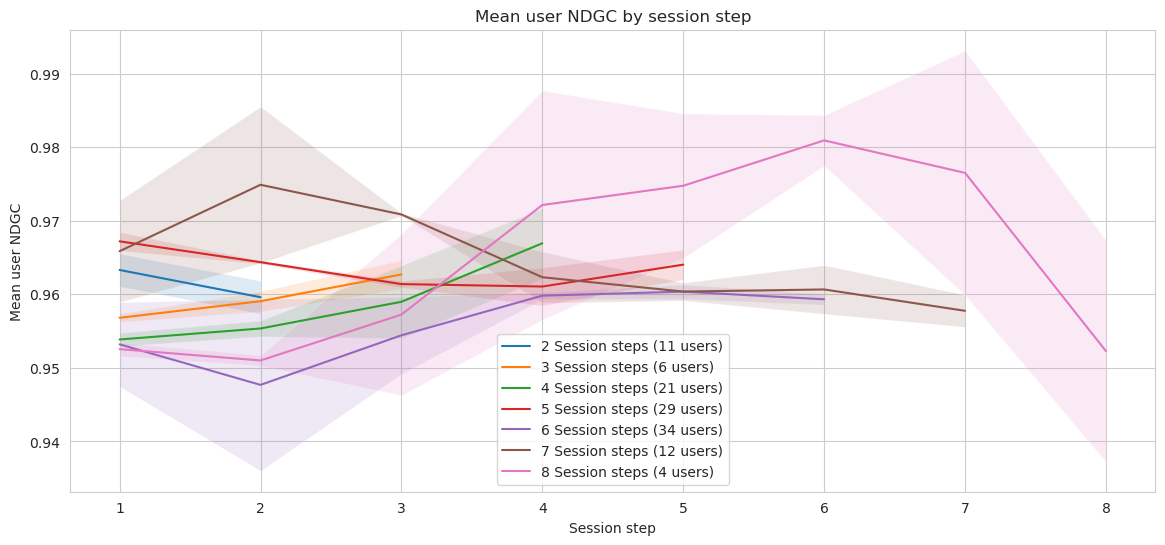

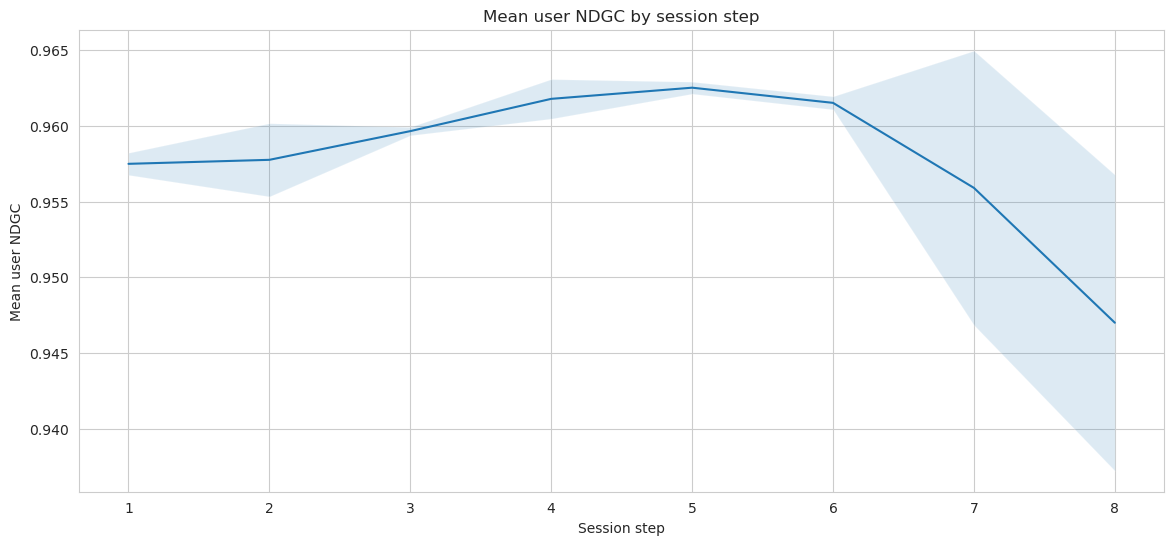

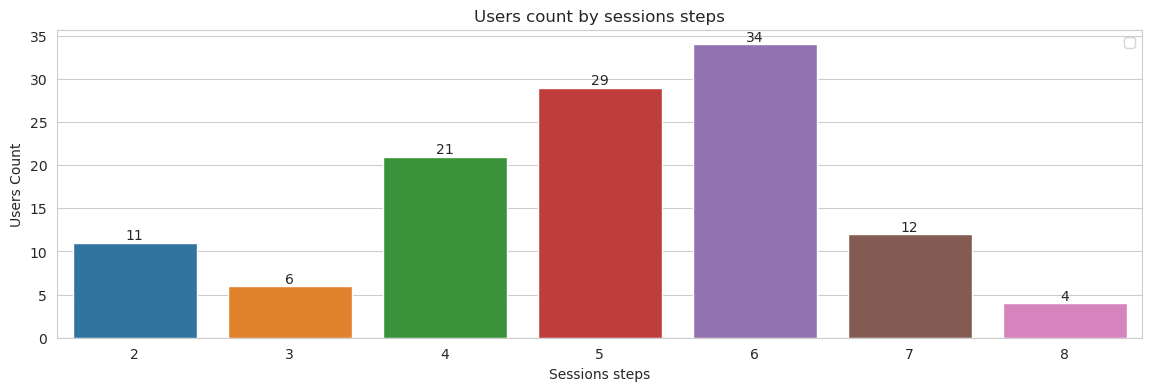

2024-04-03 10:37:30,598 - INFO - Mean Reciprocal Rank: 0.82
2024-04-03 10:37:30,600 - INFO - Mean Average Precision: 0.59
2024-04-03 10:37:30,601 - INFO - Recall: 0.71


In [45]:
ut.Picket.load(EVAL_METRICS_PATH).plot_metrics()